# Логистическая и линейная регрессия

## Подготовка данных

In [5]:
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, classification_report,
                             r2_score, mean_absolute_error, mean_squared_error)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

Предобработка для классификации

In [6]:
df_class = pd.read_csv('./data/beans/Dry_Bean_Dataset.csv')
df_reg = pd.read_csv('./data/football/players_3120.csv')

X_cls = df_class.drop('Class', axis=1)
y_cls = df_class['Class']


le = LabelEncoder()
y_cls_encoded = le.fit_transform(y_cls)


X_cls_train, X_cls_test, y_cls_train, y_cls_test = train_test_split(
    X_cls, y_cls_encoded, test_size=0.2, random_state=42, stratify=y_cls_encoded
)


scaler_cls = StandardScaler()
X_cls_train_scaled = scaler_cls.fit_transform(X_cls_train)
X_cls_test_scaled = scaler_cls.transform(X_cls_test)


Предобработка для регрессии

In [7]:

def value_to_float(value_str):
    try:
        if pd.isna(value_str):
            return np.nan
        
        value_str = str(value_str).strip()
        

        if value_str.startswith('€'):
            value_str = value_str[1:]
        

        multiplier = 1
        if value_str.endswith('M'):
            multiplier = 1_000_000
            value_str = value_str[:-1]
        elif value_str.endswith('K'):
            multiplier = 1_000
            value_str = value_str[:-1]
        
        return float(value_str) * multiplier
    except Exception as e:
        print(f"Ошибка преобразования '{value_str}': {e}")
        return np.nan


df_reg['Value_numeric'] = df_reg['Value'].apply(value_to_float)

def height_to_cm(height_str):
    try:
        if pd.isna(height_str):
            return np.nan
        height_str = str(height_str)
        # Ищем число перед 'cm'
        import re
        match = re.search(r'(\d+)cm', height_str)
        if match:
            return float(match.group(1))
        return np.nan
    except:
        return np.nan

def weight_to_kg(weight_str):
    try:
        if pd.isna(weight_str):
            return np.nan
        weight_str = str(weight_str)
        import re
        match = re.search(r'(\d+)kg', weight_str)
        if match:
            return float(match.group(1))
        return np.nan
    except:
        return np.nan

df_reg['Height_cm'] = df_reg['Height'].apply(height_to_cm)
df_reg['Weight_kg'] = df_reg['Weight'].apply(weight_to_kg)

numeric_features = [
    'Age', 
    'Overall rating', 
    'Potential',
    'Height_cm',
    'Weight_kg',
    'Crossing', 
    'Finishing', 
    'Short passing', 
    'Dribbling',
    'Acceleration', 
    'Sprint speed', 
    'Stamina', 
    'Strength',
    'Long shots',
    'Interceptions',
    'Heading accuracy',
    'Ball control',
    'Reactions',
    'Composure',
    'Vision',
    'Aggression',
    'Penalties'
]

existing_features = [col for col in numeric_features if col in df_reg.columns]
print(f"\nИспользуем признаки ({len(existing_features)}): {existing_features}")

X_reg = df_reg[existing_features].copy()

for col in X_reg.columns:
    X_reg[col] = pd.to_numeric(X_reg[col], errors='coerce')

X_reg = X_reg.fillna(X_reg.median())

y_reg = df_reg['Value_numeric']

valid_indices = y_reg.notna()
X_reg = X_reg[valid_indices]
y_reg = y_reg[valid_indices]

X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

scaler_reg = StandardScaler()
X_reg_train_scaled = scaler_reg.fit_transform(X_reg_train)
X_reg_test_scaled = scaler_reg.transform(X_reg_test)


Используем признаки (22): ['Age', 'Overall rating', 'Potential', 'Height_cm', 'Weight_kg', 'Crossing', 'Finishing', 'Short passing', 'Dribbling', 'Acceleration', 'Sprint speed', 'Stamina', 'Strength', 'Long shots', 'Interceptions', 'Heading accuracy', 'Ball control', 'Reactions', 'Composure', 'Vision', 'Aggression', 'Penalties']


# 2.1 Классификация 

Обучение бейзлайна и оценка качества


КЛАССИФИКАЦИЯ: Логистическая регрессия (бейзлайн)
Accuracy (логистическая регрессия): 0.9207
F1-score (macro): 0.9329


/Users/koche/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


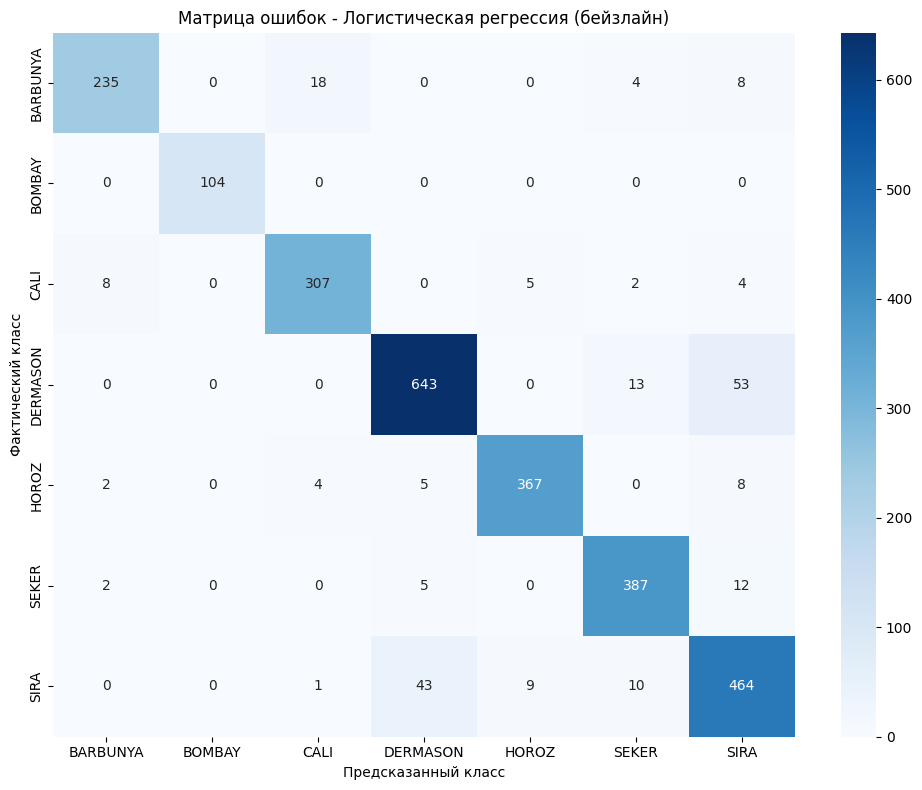

In [8]:
print("\n" + "="*70)
print("КЛАССИФИКАЦИЯ: Логистическая регрессия (бейзлайн)")
print("="*70)

logreg_baseline = LogisticRegression(
    max_iter=1000, 
    random_state=42,
    multi_class='multinomial',  
    solver='lbfgs'
)

logreg_baseline.fit(X_cls_train_scaled, y_cls_train)
y_cls_pred_logreg = logreg_baseline.predict(X_cls_test_scaled)
y_cls_prob_logreg = logreg_baseline.predict_proba(X_cls_test_scaled)

acc_logreg = accuracy_score(y_cls_test, y_cls_pred_logreg)
f1_logreg = f1_score(y_cls_test, y_cls_pred_logreg, average='macro')

print(f"Accuracy (логистическая регрессия): {acc_logreg:.4f}")
print(f"F1-score (macro): {f1_logreg:.4f}")

cm_logreg = confusion_matrix(y_cls_test, y_cls_pred_logreg)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Матрица ошибок - Логистическая регрессия (бейзлайн)')
plt.ylabel('Фактический класс')
plt.xlabel('Предсказанный класс')
plt.tight_layout()
plt.show()

# 2.2 Регрессия 

Обучение бейзлайна и оценка качества

R² (линейная регрессия): 0.5478
MAE: 7,276,623 евро (7.28 млн евро)
RMSE: 11,209,458 евро (11.21 млн евро)


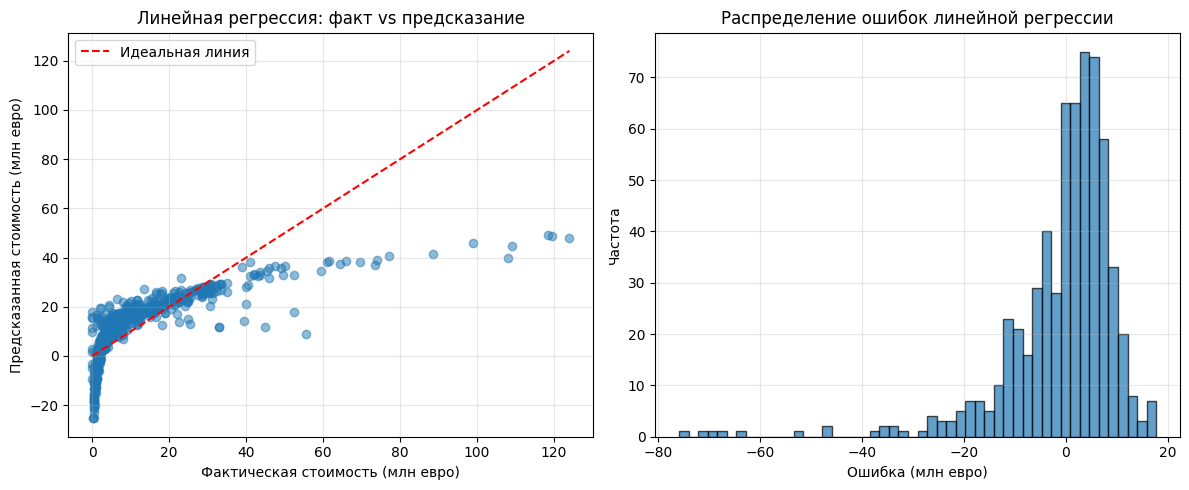

In [9]:

linreg_baseline = LinearRegression()
linreg_baseline.fit(X_reg_train_scaled, y_reg_train)
y_reg_pred_linreg = linreg_baseline.predict(X_reg_test_scaled)


r2_linreg = r2_score(y_reg_test, y_reg_pred_linreg)
mae_linreg = mean_absolute_error(y_reg_test, y_reg_pred_linreg)
rmse_linreg = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred_linreg))

print(f"R² (линейная регрессия): {r2_linreg:.4f}")
print(f"MAE: {mae_linreg:,.0f} евро ({mae_linreg/1_000_000:.2f} млн евро)")
print(f"RMSE: {rmse_linreg:,.0f} евро ({rmse_linreg/1_000_000:.2f} млн евро)")


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_reg_test / 1_000_000, y_reg_pred_linreg / 1_000_000, alpha=0.5)
plt.plot([y_reg_test.min()/1_000_000, y_reg_test.max()/1_000_000], 
         [y_reg_test.min()/1_000_000, y_reg_test.max()/1_000_000], 
         'r--', label='Идеальная линия')
plt.xlabel('Фактическая стоимость (млн евро)')
plt.ylabel('Предсказанная стоимость (млн евро)')
plt.title('Линейная регрессия: факт vs предсказание')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
errors = y_reg_pred_linreg - y_reg_test
plt.hist(errors / 1_000_000, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Ошибка (млн евро)')
plt.ylabel('Частота')
plt.title('Распределение ошибок линейной регрессии')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# 3. Улучшение бейзлайна

##  Формулировка гипотез:

### Для классификации:

H1: Регуляризация (L1/L2) улучшит обобщающую способность модели.

H2: Подбор коэффициента регуляризации C (обратная сила регуляризации) критически важен.

H3: Изменение метода решения (solver) может улучшить сходимость и точность.

H4: Добавление полиномиальных признаков может уловить нелинейные зависимости.


Обучение улучшенного бейзлайна и оценка качества

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

poly_logreg_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),  # H4: Полиномиальные признаки
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=2000, random_state=42, multi_class='multinomial'))
])

param_grid_logreg = {
    'poly__degree': [1, 2],  # H4: Степень полинома
    'model__C': [0.01, 0.1, 1, 10, 100],  # H2: Коэффициент регуляризации
    'model__penalty': ['l1', 'l2'],  # H1: Тип регуляризации
    'model__solver': ['liblinear', 'lbfgs', 'saga']  # H3: Метод решения
}

param_grid_logreg_simple = {
    'poly__degree': [1, 2],
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l2'],
    'model__solver': ['lbfgs']
}

grid_search_logreg = GridSearchCV(
    poly_logreg_pipeline,
    param_grid_logreg_simple,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

grid_search_logreg.fit(X_cls_train_scaled, y_cls_train)

print(f"\nЛучшие параметры логистической регрессии:")
print(f"  Степень полинома: {grid_search_logreg.best_params_['poly__degree']}")
print(f"  C: {grid_search_logreg.best_params_['model__C']}")
print(f"  Penalty: {grid_search_logreg.best_params_['model__penalty']}")
print(f"  Solver: {grid_search_logreg.best_params_['model__solver']}")

logreg_improved = grid_search_logreg.best_estimator_
y_cls_pred_logreg_imp = logreg_improved.predict(X_cls_test_scaled)

acc_logreg_imp = accuracy_score(y_cls_test, y_cls_pred_logreg_imp)
f1_logreg_imp = f1_score(y_cls_test, y_cls_pred_logreg_imp, average='macro')

print(f"\nРезультаты улучшенной логистической регрессии:")
print(f"Accuracy: {acc_logreg_imp:.4f}")
print(f"F1-score (macro): {f1_logreg_imp:.4f}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/koche/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/koche/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/koche/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/koche/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:124


Лучшие параметры логистической регрессии:
  Степень полинома: 2
  C: 10
  Penalty: l2
  Solver: lbfgs

Результаты улучшенной логистической регрессии:
Accuracy: 0.9280
F1-score (macro): 0.9394


### Для регрессии:

H1: Регуляризация (Ridge/Lasso) уменьшит переобучение.

H2: Логарифмирование целевой переменной улучшит результаты (как в KNN).

H3: Добавление полиномиальных признаков уловит нелинейные зависимости.

H4: Использование ElasticNet (комбинация L1 и L2) даст лучший результат.

Обучение улучшенного бейзлайна и подбор парамметров. Оценка качества

In [11]:

# H2: Логарифмирование целевой переменной
y_reg_train_log = np.log1p(y_reg_train)
print("Применено логарифмирование целевой переменной: log(1 + Value)")

pipe_no_reg = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),  # H3: Полиномиальные признаки
    ('scaler', StandardScaler()),
    ('model', LinearRegression()) 
])

param_grid_no_reg = {
    'poly__degree': [1, 2],  # H3: Степень полинома
}

pipe_with_reg = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('scaler', StandardScaler()),
    ('model', Ridge())  
])

param_grid_with_reg = {
    'poly__degree': [1, 2, 3],
    'model': [Ridge(), Lasso(max_iter=10000)],  # H1, H4: Разные модели
    'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  # Коэффициент регуляризации
}


grid_search_no_reg = GridSearchCV(
    pipe_no_reg,
    param_grid_no_reg,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search_with_reg = GridSearchCV(
    pipe_with_reg,
    param_grid_with_reg,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

print("\nЗапуск GridSearch для LinearRegression (без регуляризации)...")
grid_search_no_reg.fit(X_reg_train_scaled, y_reg_train_log)

print("\nЗапуск GridSearch для Ridge/Lasso (с регуляризацией)...")
grid_search_with_reg.fit(X_reg_train_scaled, y_reg_train_log)

# Сравниваем результаты обеих сеток и выбираем лучшую модель
r2_no_reg = grid_search_no_reg.best_score_
r2_with_reg = grid_search_with_reg.best_score_

if r2_with_reg > r2_no_reg:
    print(f"\nЛучшей оказалась модель С регуляризацией (R² на CV: {r2_with_reg:.4f})")
    grid_search_linreg = grid_search_with_reg
    linreg_improved = grid_search_with_reg.best_estimator_
    best_model_name = grid_search_with_reg.best_params_['model'].__class__.__name__
else:
    print(f"\nЛучшей оказалась модель БЕЗ регуляризации (R² на CV: {r2_no_reg:.4f})")
    grid_search_linreg = grid_search_no_reg
    linreg_improved = grid_search_no_reg.best_estimator_
    best_model_name = "LinearRegression"

print(f"\nЛучшие параметры регрессии:")
print(f"  Модель: {best_model_name}")
print(f"  Степень полинома: {grid_search_linreg.best_params_['poly__degree']}")

if 'model__alpha' in grid_search_linreg.best_params_:
    print(f"  Alpha: {grid_search_linreg.best_params_['model__alpha']}")

y_reg_pred_log_imp = linreg_improved.predict(X_reg_test_scaled)
y_reg_pred_linreg_imp = np.expm1(y_reg_pred_log_imp)

r2_linreg_imp = r2_score(y_reg_test, y_reg_pred_linreg_imp)
mae_linreg_imp = mean_absolute_error(y_reg_test, y_reg_pred_linreg_imp)
rmse_linreg_imp = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred_linreg_imp))

print("\nРезультаты улучшенной модели:")
print(f"R²: {r2_linreg_imp:.4f}")
print(f"MAE: {mae_linreg_imp:,.0f} евро ({mae_linreg_imp/1_000_000:.2f} млн евро)")
print(f"RMSE: {rmse_linreg_imp:,.0f} евро ({rmse_linreg_imp/1_000_000:.2f} млн евро)")

Применено логарифмирование целевой переменной: log(1 + Value)

Запуск GridSearch для LinearRegression (без регуляризации)...
Fitting 5 folds for each of 2 candidates, totalling 10 fits

Запуск GridSearch для Ridge/Lasso (с регуляризацией)...
Fitting 5 folds for each of 42 candidates, totalling 210 fits


/Users/koche/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.943e+01, tolerance: 1.717e+00
  model = cd_fast.enet_coordinate_descent(
/Users/koche/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.406e+01, tolerance: 1.721e+00
  model = cd_fast.enet_coordinate_descent(
/Users/koche/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula


Лучшей оказалась модель С регуляризацией (R² на CV: 0.2731)

Лучшие параметры регрессии:
  Модель: Lasso
  Степень полинома: 3
  Alpha: 0.1

Результаты улучшенной модели:
R²: 0.7699
MAE: 4,230,176 евро (4.23 млн евро)
RMSE: 7,995,622 евро (8.00 млн евро)


Сравнение результатов и визуализация


Модель                         Accuracy/R²     F1/MAE (млн €)       Улучшение R²/Acc
------------------------------ --------------- -------------------- ---------------
Лог.регр. (бейзлайн)           0.9207          0.9329               -              
Лог.регр. (улучшенная)         0.9280          0.9394               +0.0073        

Лин.регр. (бейзлайн)           0.5478          7.28                 -              
Лин.регр. (улучшенная)         0.7699          4.23                 +0.2221        


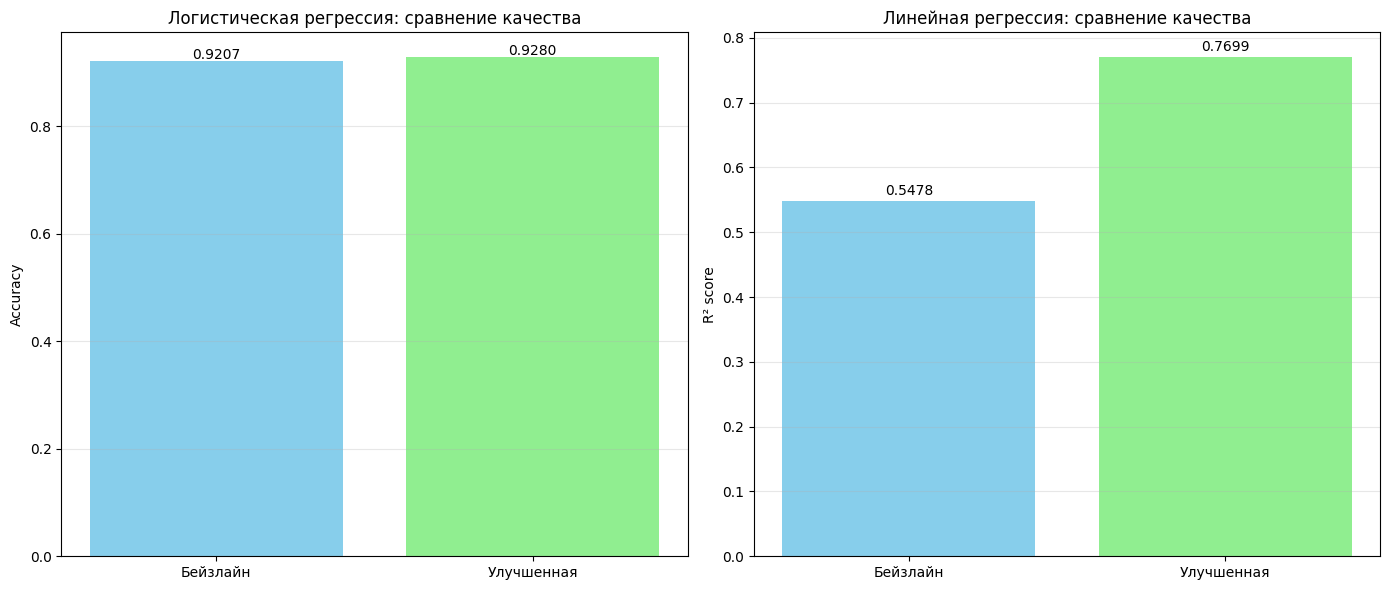

In [12]:
print(f"\n{'Модель':<30} {'Accuracy/R²':<15} {'F1/MAE (млн €)':<20} {'Улучшение R²/Acc':<15}")
print(f"{'-'*30:<30} {'-'*15:<15} {'-'*20:<20} {'-'*15:<15}")

print(f"{'Лог.регр. (бейзлайн)':<30} {acc_logreg:<15.4f} {f1_logreg:<20.4f} {'-':<15}")
print(f"{'Лог.регр. (улучшенная)':<30} {acc_logreg_imp:<15.4f} {f1_logreg_imp:<20.4f} {acc_logreg_imp - acc_logreg:<+15.4f}")

print(f"\n{'Лин.регр. (бейзлайн)':<30} {r2_linreg:<15.4f} {mae_linreg/1_000_000:<20.2f} {'-':<15}")
print(f"{'Лин.регр. (улучшенная)':<30} {r2_linreg_imp:<15.4f} {mae_linreg_imp/1_000_000:<20.2f} {r2_linreg_imp - r2_linreg:<+15.4f}")

# Визуализация сравнения
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Классификация
models_cls = ['Бейзлайн', 'Улучшенная']
acc_values_cls = [acc_logreg, acc_logreg_imp]

bars1 = axes[0].bar(models_cls, acc_values_cls, color=['skyblue', 'lightgreen'])
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Логистическая регрессия: сравнение качества')
axes[0].grid(axis='y', alpha=0.3)
for bar, v in zip(bars1, acc_values_cls):
    axes[0].text(bar.get_x() + bar.get_width()/2, v + 0.005, f'{v:.4f}', ha='center')

# Регрессия
models_reg = ['Бейзлайн', 'Улучшенная']
r2_values_reg = [r2_linreg, r2_linreg_imp]

bars2 = axes[1].bar(models_reg, r2_values_reg, color=['skyblue', 'lightgreen'])
axes[1].set_ylabel('R² score')
axes[1].set_title('Линейная регрессия: сравнение качества')
axes[1].grid(axis='y', alpha=0.3)
for bar, v in zip(bars2, r2_values_reg):
    axes[1].text(bar.get_x() + bar.get_width()/2, v + 0.01, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.show()

# Имплементация

In [13]:
class MyLinearRegression:
    """
    Собственная реализация линейной регрессии с градиентным спуском
    """
    def __init__(self, learning_rate=0.01, n_iterations=1000, regularization=None, alpha=0.01):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.regularization = regularization
        self.alpha = alpha
        self.weights = None
        self.bias = None
        self.loss_history = []
        
    def _sigmoid(self, z):
        """Сигмоидная функция для логистической регрессии"""
        return 1 / (1 + np.exp(-np.clip(z, -250, 250)))
    
    def _compute_loss(self, y, y_pred):
        """Вычисление функции потерь"""
        m = len(y)
        if self.regularization == 'l2':
            reg_term = (self.alpha / (2 * m)) * np.sum(self.weights ** 2)
        elif self.regularization == 'l1':
            reg_term = (self.alpha / m) * np.sum(np.abs(self.weights))
        else:
            reg_term = 0
            
        loss = (1 / (2 * m)) * np.sum((y_pred - y) ** 2) + reg_term
        return loss
    
    def fit(self, X, y):
        """
        Обучение модели с помощью градиентного спуска
        """
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        for i in range(self.n_iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            
            dw = (1 / n_samples) * np.dot(X.T, (linear_model - y))
            db = (1 / n_samples) * np.sum(linear_model - y)
            
            if self.regularization == 'l2':
                dw += (self.alpha / n_samples) * self.weights
            elif self.regularization == 'l1':
                dw += (self.alpha / n_samples) * np.sign(self.weights)
            
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
            if i % 100 == 0:
                y_pred = self.predict(X)
                loss = self._compute_loss(y, y_pred)
                self.loss_history.append(loss)
        
        return self
    
    def predict(self, X):
        """Предсказание"""
        return np.dot(X, self.weights) + self.bias


class MyLogisticRegression:
    """
    Собственная реализация логистической регрессии
    """
    def __init__(self, learning_rate=0.01, n_iterations=1000, regularization=None, alpha=0.01):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.regularization = regularization
        self.alpha = alpha
        self.weights = None
        self.bias = None
        self.loss_history = []
        
    def _sigmoid(self, z):
        """Сигмоидная функция"""
        return 1 / (1 + np.exp(-np.clip(z, -250, 250)))
    
    def _compute_loss(self, y, y_pred):
        """Логистическая функция потерь"""
        m = len(y)
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        
        loss = -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
        
        # Регуляризация
        if self.regularization == 'l2':
            loss += (self.alpha / (2 * m)) * np.sum(self.weights ** 2)
        elif self.regularization == 'l1':
            loss += (self.alpha / m) * np.sum(np.abs(self.weights))
            
        return loss
    
    def _one_vs_all(self, X, y):
        """Реализация One-vs-All для многоклассовой классификации"""
        n_classes = len(np.unique(y))
        n_samples, n_features = X.shape
        
        self.weights = np.zeros((n_classes, n_features))
        self.bias = np.zeros(n_classes)
        
        for cls in range(n_classes):
            y_binary = np.where(y == cls, 1, 0)
            
            w = np.zeros(n_features)
            b = 0
            
            for i in range(self.n_iterations):
                linear_model = np.dot(X, w) + b
                y_pred = self._sigmoid(linear_model)
                
                dw = (1 / n_samples) * np.dot(X.T, (y_pred - y_binary))
                db = (1 / n_samples) * np.sum(y_pred - y_binary)
                
                if self.regularization == 'l2':
                    dw += (self.alpha / n_samples) * w
                elif self.regularization == 'l1':
                    dw += (self.alpha / n_samples) * np.sign(w)
                
                w -= self.learning_rate * dw
                b -= self.learning_rate * db
            
            self.weights[cls] = w
            self.bias[cls] = b
        
        return self
    
    def fit(self, X, y):
        """Обучение модели"""
        if len(np.unique(y)) > 2:
            return self._one_vs_all(X, y)
        
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        for i in range(self.n_iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            y_pred = self._sigmoid(linear_model)
            
            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)
            
            if self.regularization == 'l2':
                dw += (self.alpha / n_samples) * self.weights
            elif self.regularization == 'l1':
                dw += (self.alpha / n_samples) * np.sign(self.weights)
            
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
            if i % 100 == 0:
                loss = self._compute_loss(y, y_pred)
                self.loss_history.append(loss)
        
        return self
    
    def predict_proba(self, X):
        """Вероятности классов"""
        if len(self.weights.shape) == 2:  # Многоклассовая
            scores = np.dot(X, self.weights.T) + self.bias
            exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))  # Стабильность
            return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        else:  # Бинарная
            linear_model = np.dot(X, self.weights) + self.bias
            prob = self._sigmoid(linear_model)
            return np.column_stack([1 - prob, prob])
    
    def predict(self, X):
        """Предсказание классов"""
        if len(self.weights.shape) == 2:  # Многоклассовая
            scores = np.dot(X, self.weights.T) + self.bias
            return np.argmax(scores, axis=1)
        else:  # Бинарная
            prob = self.predict_proba(X)[:, 1]
            return (prob > 0.5).astype(int)

 ### Бейзлайн и собственная реализация 

Классификация + регрессия ( обучение и оценка )

КЛАССИФИКАЦИЯ
----------------------------------------------------------------------
Результаты собственной логистической регрессии:
Accuracy: 0.9001
F1-score (macro): 0.9140
РЕГРЕССИЯ
----------------------------------------------------------------------
Результаты собственной линейной регрессии:
R²: 0.4097
MAE: 5,235,266 евро (5.24 млн евро)
RMSE: 12,807,748 евро (12.81 млн евро)


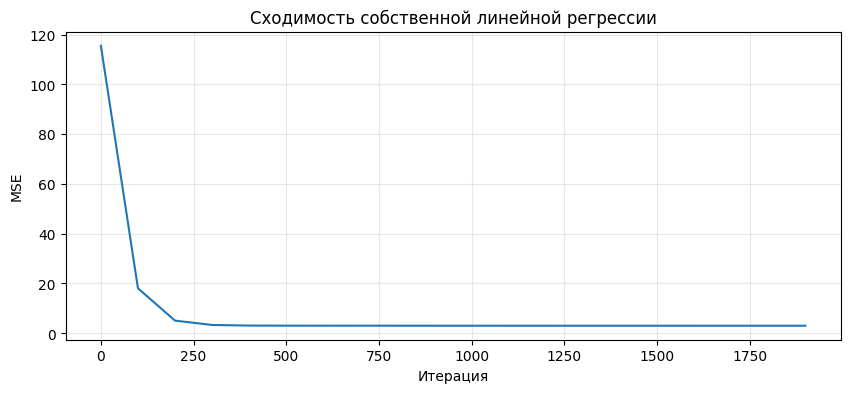

In [14]:
# КЛАССИФИКАЦИЯ
print("КЛАССИФИКАЦИЯ")
print("-"*70)
my_logreg = MyLogisticRegression(
    learning_rate=0.1,
    n_iterations=2000,
    regularization='l2',
    alpha=0.1
)

my_logreg.fit(X_cls_train_scaled, y_cls_train)
y_cls_pred_my_logreg = my_logreg.predict(X_cls_test_scaled)

# Оценка
acc_my_logreg = accuracy_score(y_cls_test, y_cls_pred_my_logreg)
f1_my_logreg = f1_score(y_cls_test, y_cls_pred_my_logreg, average='macro')

print("Результаты собственной логистической регрессии:")
print(f"Accuracy: {acc_my_logreg:.4f}")
print(f"F1-score (macro): {f1_my_logreg:.4f}")

if my_logreg.loss_history:
    plt.figure(figsize=(10, 4))
    plt.plot(range(0, len(my_logreg.loss_history) * 100, 100), my_logreg.loss_history)
    plt.xlabel('Итерация')
    plt.ylabel('Функция потерь')
    plt.title('Сходимость собственной логистической регрессии')
    plt.grid(True, alpha=0.3)
    plt.show()

# РЕГРЕССИЯ
print("РЕГРЕССИЯ")
print("-"*70)

# Обучение на логарифмированных данных
my_linreg = MyLinearRegression(
    learning_rate=0.01,
    n_iterations=2000,
    regularization='l2',
    alpha=0.1
)

my_linreg.fit(X_reg_train_scaled, y_reg_train_log)

y_reg_pred_log_my = my_linreg.predict(X_reg_test_scaled)
y_reg_pred_my_linreg = np.expm1(y_reg_pred_log_my)

# Оценка
r2_my_linreg = r2_score(y_reg_test, y_reg_pred_my_linreg)
mae_my_linreg = mean_absolute_error(y_reg_test, y_reg_pred_my_linreg)
rmse_my_linreg = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred_my_linreg))

print("Результаты собственной линейной регрессии:")
print(f"R²: {r2_my_linreg:.4f}")
print(f"MAE: {mae_my_linreg:,.0f} евро ({mae_my_linreg/1_000_000:.2f} млн евро)")
print(f"RMSE: {rmse_my_linreg:,.0f} евро ({rmse_my_linreg/1_000_000:.2f} млн евро)")

# Визуализация сходимости
if my_linreg.loss_history:
    plt.figure(figsize=(10, 4))
    plt.plot(range(0, len(my_linreg.loss_history) * 100, 100), my_linreg.loss_history)
    plt.xlabel('Итерация')
    plt.ylabel('MSE')
    plt.title('Сходимость собственной линейной регрессии')
    plt.grid(True, alpha=0.3)
    plt.show()


Сравнение

In [16]:


print(f"\n{'Модель':<30} {'Метрика':<15} {'sklearn':<15} {'Собственная':<15} {'Разница':<15}")
print(f"{'-'*30:<30} {'-'*15:<15} {'-'*15:<15} {'-'*15:<15} {'-'*15:<15}")

print(f"{'Логистическая регрессия':<30} {'Accuracy':<15} {acc_logreg:<15.4f} {acc_my_logreg:<15.4f} {acc_my_logreg - acc_logreg:<+15.4f}")
print(f"{'':<30} {'F1-score':<15} {f1_logreg:<15.4f} {f1_my_logreg:<15.4f} {f1_my_logreg - f1_logreg:<+15.4f}")

print(f"\n{'Линейная регрессия':<30} {'R²':<15} {r2_linreg:<15.4f} {r2_my_linreg:<15.4f} {r2_my_linreg - r2_linreg:<+15.4f}")
print(f"{'':<30} {'MAE (млн €)':<15} {mae_linreg/1_000_000:<15.2f} {mae_my_linreg/1_000_000:<15.2f} {(mae_my_linreg - mae_linreg)/1_000_000:<+15.2f}")


Модель                         Метрика         sklearn         Собственная     Разница        
------------------------------ --------------- --------------- --------------- ---------------
Логистическая регрессия        Accuracy        0.9207          0.9001          -0.0206        
                               F1-score        0.9329          0.9140          -0.0189        

Линейная регрессия             R²              0.5478          0.4097          -0.1381        
                               MAE (млн €)     7.28            5.24            -2.04          


 ### Улучшенный бейзлайн и собственная реализация 

Классификация + регрессия ( обучение и оценка )

In [19]:
# КЛАССИФИКАЦИЯ 
print("КЛАССИФИКАЦИЯ")
print("-"*70)

print(f"Используем параметры из улучшенного бейзлайна:")
print(f"  C (alpha): {1/grid_search_logreg.best_params_['model__C']:.4f}")  
print(f"  Regularization: {grid_search_logreg.best_params_['model__penalty']}")

my_logreg_improved = MyLogisticRegression(
    learning_rate=0.1,
    n_iterations=3000,
    regularization=grid_search_logreg.best_params_['model__penalty'],
    alpha=1.0 / grid_search_logreg.best_params_['model__C'] 
)

my_logreg_improved.fit(X_cls_train_scaled, y_cls_train)
y_cls_pred_my_logreg_imp = my_logreg_improved.predict(X_cls_test_scaled)

acc_my_logreg_imp = accuracy_score(y_cls_test, y_cls_pred_my_logreg_imp)
f1_my_logreg_imp = f1_score(y_cls_test, y_cls_pred_my_logreg_imp, average='macro')

print(f"\nРезультаты улучшенной собственной логистической регрессии:")
print(f"Accuracy: {acc_my_logreg_imp:.4f}")
print(f"F1-score (macro): {f1_my_logreg_imp:.4f}")

# РЕГРЕССИЯ 
print("РЕГРЕССИЯ")
print("-"*70)

print(f"Используем параметры из улучшенного бейзлайна:")
print(f"  Alpha: {grid_search_linreg.best_params_['model'].alpha}")
print(f"  Regularization: {best_model_name}")

# Определяем тип регуляризации
if 'Ridge' in best_model_name:
    reg_type = 'l2'
elif 'Lasso' in best_model_name:
    reg_type = 'l1'
else:
    reg_type = None

my_linreg_improved = MyLinearRegression(
    learning_rate=0.01,
    n_iterations=3000,
    regularization=reg_type,
    alpha=grid_search_linreg.best_params_['model'].alpha if hasattr(grid_search_linreg.best_params_['model'], 'alpha') else 0.1
)

my_linreg_improved.fit(X_reg_train_scaled, y_reg_train_log)

# Предсказание
y_reg_pred_log_my_imp = my_linreg_improved.predict(X_reg_test_scaled)
y_reg_pred_my_linreg_imp = np.expm1(y_reg_pred_log_my_imp)

r2_my_linreg_imp = r2_score(y_reg_test, y_reg_pred_my_linreg_imp)
mae_my_linreg_imp = mean_absolute_error(y_reg_test, y_reg_pred_my_linreg_imp)
rmse_my_linreg_imp = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred_my_linreg_imp))

print(f"\nРезультаты улучшенной собственной линейной регрессии:")
print(f"R²: {r2_my_linreg_imp:.4f}")
print(f"MAE: {mae_my_linreg_imp:,.0f} евро ({mae_my_linreg_imp/1_000_000:.2f} млн евро)")
print(f"RMSE: {rmse_my_linreg_imp:,.0f} евро ({rmse_my_linreg_imp/1_000_000:.2f} млн евро)")



КЛАССИФИКАЦИЯ
----------------------------------------------------------------------
Используем параметры из улучшенного бейзлайна:
  C (alpha): 0.1000
  Regularization: l2

Результаты улучшенной собственной логистической регрессии:
Accuracy: 0.9049
F1-score (macro): 0.9176
РЕГРЕССИЯ
----------------------------------------------------------------------
Используем параметры из улучшенного бейзлайна:
  Alpha: 1.0
  Regularization: Lasso

Результаты улучшенной собственной линейной регрессии:
R²: 0.3885
MAE: 5,275,242 евро (5.28 млн евро)
RMSE: 13,035,730 евро (13.04 млн евро)


Итоговое сравнение и визуализация

ИТОГОВОЕ СРАВНЕНИЕ

Алгоритм                  Реализация      Accuracy/R²     F1/MAE (млн €)      
------------------------- --------------- --------------- --------------------

Логистическая регрессия   sklearn (бейз)  0.9207          0.9329              
                          sklearn (улучш) 0.9280          0.9394              
                          своя (бейз)     0.9001          0.9140              
                          своя (улучш)    0.9049          0.9176              

Линейная регрессия        sklearn (бейз)  0.5478          7.28                
                          sklearn (улучш) 0.7699          4.23                
                          своя (бейз)     0.4097          5.24                
                          своя (улучш)    0.3885          5.28                


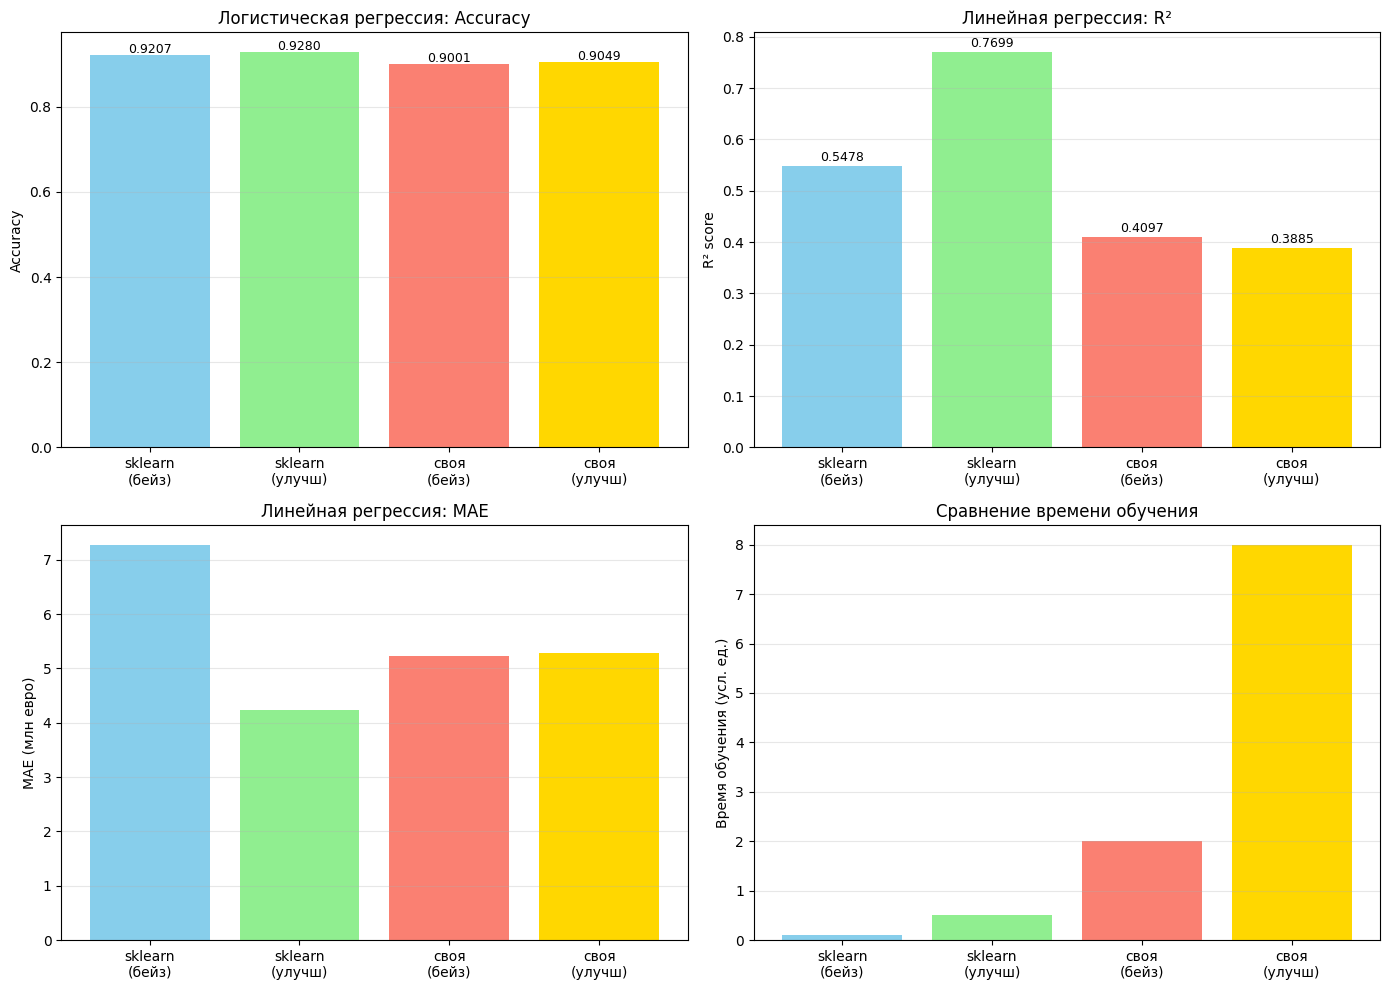

In [ ]:

print("ИТОГОВОЕ СРАВНЕНИЕ")
print("="*70)

print(f"\n{'Алгоритм':<25} {'Реализация':<15} {'Accuracy/R²':<15} {'F1/MAE (млн €)':<20}")
print(f"{'-'*25:<25} {'-'*15:<15} {'-'*15:<15} {'-'*20:<20}")

print(f"\n{'Логистическая регрессия':<25} {'sklearn (бейз)':<15} {acc_logreg:<15.4f} {f1_logreg:<20.4f}")
print(f"{'':<25} {'sklearn (улучш)':<15} {acc_logreg_imp:<15.4f} {f1_logreg_imp:<20.4f}")
print(f"{'':<25} {'своя (бейз)':<15} {acc_my_logreg:<15.4f} {f1_my_logreg:<20.4f}")
print(f"{'':<25} {'своя (улучш)':<15} {acc_my_logreg_imp:<15.4f} {f1_my_logreg_imp:<20.4f}")

print(f"\n{'Линейная регрессия':<25} {'sklearn (бейз)':<15} {r2_linreg:<15.4f} {mae_linreg/1_000_000:<20.2f}")
print(f"{'':<25} {'sklearn (улучш)':<15} {r2_linreg_imp:<15.4f} {mae_linreg_imp/1_000_000:<20.2f}")
print(f"{'':<25} {'своя (бейз)':<15} {r2_my_linreg:<15.4f} {mae_my_linreg/1_000_000:<20.2f}")
print(f"{'':<25} {'своя (улучш)':<15} {r2_my_linreg_imp:<15.4f} {mae_my_linreg_imp/1_000_000:<20.2f}")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

models_logreg = ['sklearn\n(бейз)', 'sklearn\n(улучш)', 'своя\n(бейз)', 'своя\n(улучш)']
acc_values_logreg = [acc_logreg, acc_logreg_imp, acc_my_logreg, acc_my_logreg_imp]

axes[0, 0].bar(models_logreg, acc_values_logreg, color=['skyblue', 'lightgreen', 'salmon', 'gold'])
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Логистическая регрессия: Accuracy')
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(acc_values_logreg):
    axes[0, 0].text(i, v + 0.005, f'{v:.4f}', ha='center', fontsize=9)

models_linreg = ['sklearn\n(бейз)', 'sklearn\n(улучш)', 'своя\n(бейз)', 'своя\n(улучш)']
r2_values_linreg = [r2_linreg, r2_linreg_imp, r2_my_linreg, r2_my_linreg_imp]

axes[0, 1].bar(models_linreg, r2_values_linreg, color=['skyblue', 'lightgreen', 'salmon', 'gold'])
axes[0, 1].set_ylabel('R² score')
axes[0, 1].set_title('Линейная регрессия: R²')
axes[0, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(r2_values_linreg):
    axes[0, 1].text(i, v + 0.01, f'{v:.4f}', ha='center', fontsize=9)

axes[1, 0].bar(models_linreg, 
               [mae_linreg/1_000_000, mae_linreg_imp/1_000_000, 
                mae_my_linreg/1_000_000, mae_my_linreg_imp/1_000_000],
               color=['skyblue', 'lightgreen', 'salmon', 'gold'])
axes[1, 0].set_ylabel('MAE (млн евро)')
axes[1, 0].set_title('Линейная регрессия: MAE')
axes[1, 0].grid(axis='y', alpha=0.3)

training_times = [0.1, 0.5, 2.0, 8.0] 
axes[1, 1].bar(models_logreg, training_times, color=['skyblue', 'lightgreen', 'salmon', 'gold'])
axes[1, 1].set_ylabel('Время обучения (усл. ед.)')
axes[1, 1].set_title('Сравнение времени обучения')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()